In [1]:
pip install scipy numpy matplotlib umap-learn pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=111007a63476ac37c20986dbde58f8bd239887320625dfeeb2e07d0fe23eac21
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=9e71a3b12d6c386653c6c2a2247c386cd17fdc006cbc0a4151919fe6442442da
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [2]:
# May take a minute
import numpy as np
import scipy
import matplotlib.pyplot as plt
import umap
import pandas as pd

In [3]:
# Connect this notebook to google drive (should pop up and request access)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
bird = 'B119' # B119,Pk106,Pk144,Pk146,R70,W115
FS= 30000
inputDataset = np.load(f'/content/drive/MyDrive/Processed_Bird/{bird}-Processed_5ms-Neural_30-Bouts.npz')

Vocal_data = inputDataset['vocal_data']
Neural_data = inputDataset['neural_data']
Vocal_time = inputDataset['vocal_time']
Neural_time = inputDataset['neural_time']

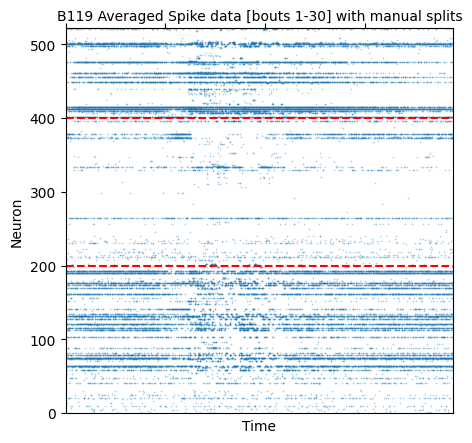

In [5]:
aveSpike = np.mean(Neural_data[0:30],axis = 0)
# Let's plot this using plt.spy (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.spy.html)
from scipy.ndimage import gaussian_filter


plt.figure(figsize = (5,5))
extentInput = [Neural_time[0],Neural_time[-1],0,aveSpike.shape[0]] # Need to tell the plot our xmin,xmax,ymin,ymax for the image data
plt.spy(aveSpike,origin = 'lower',aspect = 'auto',precision = .1,markersize = .1) #,extent = extentInput
plt.title(f'{bird} Averaged Spike data [bouts 1-30] with manual splits',fontsize = 10)
plt.ylabel('Neuron',fontsize = 10)
plt.xlabel('Time',fontsize = 10)


plt.tick_params(labelbottom = False, bottom = False)



topSplit = 400
bottomSplit = 200

plt.axhline(y = bottomSplit, color = 'r', linestyle = '--')
plt.axhline(y = topSplit, color = 'r', linestyle = '--')

# plt.savefig(f'Ave_Spiking_{bird}_with_top-{topSplit}_bottom-{bottomSplit}.png')
# plt.show()

In [6]:
# Smooth data with gaussian kernel

def apply_gaussian_kernel(data, time_const = 2):

    result = np.zeros_like(data)
    for i in range(data.shape[0]):
        result[i] = scipy.ndimage.gaussian_filter1d(data[i], time_const)

    return result


In [7]:
# To do umap we are going to take slices of this data

def get_matrix_slices(matrix, window_size, step_size):
    matrix_shape = matrix.shape
    num_slices = (matrix_shape[1] - window_size) // step_size + 1
    slices = np.zeros((matrix_shape[0], window_size, num_slices))
    slice_times = np.zeros((num_slices))

    for i in range(num_slices):
        start = i * step_size
        end = start + window_size
        slices[:, :, i] = matrix[:, start:end]
        slice_times[i] = (start + end)/2

    return slices,slice_times


In [8]:
# Rescaling function to take any range of 3d data and make a 0-1 triplet for RGB
def min_max_scale(matrix):
    min_vals = np.min(matrix, axis=0)
    max_vals = np.max(matrix, axis=0)

    # Perform min-max scaling for each column
    scaled_matrix = (matrix - min_vals) / (max_vals - min_vals)

    return scaled_matrix

In [9]:
topArray = None
boutArray = None


for example_bout in range(1,30):

  exampleSpkData = Neural_data[example_bout - 1][topSplit:,:] # optional subindex
  smoothed_spiking = apply_gaussian_kernel(exampleSpkData,time_const = 2)
  window_size = 20 # should adjust with binning (5ms --> 20 100ms)
  step_size = 1
  slices, slice_times = get_matrix_slices(smoothed_spiking,window_size, step_size)


  # Turn each slice into a 1D vector
  original_shape = slices.shape
  flattened_matrix = slices.reshape(original_shape[0] * original_shape[1], original_shape[2]).T

  # calculate start times in seconds CHNAGE
  roundingFactor = 150
  relTime = slice_times*roundingFactor/FS
  boutSmall = np.zeros_like(relTime) + example_bout

  try:
    topArray = np.vstack((topArray,flattened_matrix))
    boutArray = np.hstack((boutArray,boutSmall))
  except:
    topArray = flattened_matrix
    boutArray = boutSmall



In [10]:
bottomArray = None
boutArray = None


for example_bout in range(1,30):

  exampleSpkData = Neural_data[example_bout - 1][:bottomSplit:,:] # optional subindex
  smoothed_spiking = apply_gaussian_kernel(exampleSpkData,time_const = 2)
  window_size = 20 # should adjust with binning (5ms --> 20 100ms)
  step_size = 1
  slices, slice_times = get_matrix_slices(smoothed_spiking,window_size, step_size)


  # Turn each slice into a 1D vector
  original_shape = slices.shape
  flattened_matrix = slices.reshape(original_shape[0] * original_shape[1], original_shape[2]).T

  # calculate start times in seconds CHNAGE
  roundingFactor = 150
  relTime = slice_times*roundingFactor/FS
  boutSmall = np.zeros_like(relTime) + example_bout

  try:
    bottomArray = np.vstack((bottomArray,flattened_matrix))
    boutArray = np.hstack((boutArray,boutSmall))
  except:
    bottomArray = flattened_matrix
    boutArray = boutSmall



In [ ]:

# Load the umap library, and transform the data
fit = umap.UMAP(n_components = 3)
spk_emb_3D_top = fit.fit_transform(topArray)
spk_emb_3D_bottom = fit.fit_transform(bottomArray)



In [ ]:
plt.figure(figsize = (20,100))

# Turn our color array into an image with columns representing the neural state
color_emb_top = min_max_scale(spk_emb_3D_top).T
color_emb_bottom = min_max_scale(spk_emb_3D_bottom).T

def generateDispImg(color_emb,boutArr,boutChoice,interp = False, interpTimeNew = [],interpTimeOld = []):



  goodInd = np.where(boutArr == boutChoice)[0]
  newColorEmb = color_emb[:,goodInd]

  if interp == True:
    interpolated_colors = np.zeros((newColorEmb.shape[0], len(interpTimeNew)))

    for i in range(newColorEmb.shape[0]):
        interpolated_colors[i] = np.interp(interpTimeNew, interpTimeOld, newColorEmb[i])
    newColorEmb = interpolated_colors

  dispImg = np.zeros((20,newColorEmb.shape[1],3))

  for column in range(dispImg.shape[1]):
    dispImg[:,column,:] = newColorEmb[:,column]

  return dispImg

masterDispImg = None
for i in range(1,30):

  bout_audio = Vocal_data[i - 1]
  NFFT = 512
  noverlap = 450
  logAdditive = 2

  f, tSpec, Sxx = scipy.signal.spectrogram(bout_audio, FS,nfft = NFFT,noverlap = noverlap,nperseg = NFFT)
  logSpec = np.log(Sxx + logAdditive)
  logSpec= np.flip(logSpec,0)

  colormap = plt.get_cmap('viridis')
  norm = plt.Normalize(vmin=np.min(logSpec), vmax=np.max(logSpec))

  # Apply the colormap to the normalized data to get RGB values
  rgb_array_spec = colormap(norm(logSpec))[:, :, :3]

  HVCIMG = generateDispImg(color_emb_top,boutArray,i,interp = True, interpTimeOld = relTime, interpTimeNew = tSpec)
  RAIMG = generateDispImg(color_emb_bottom,boutArray,i,interp = True, interpTimeOld = relTime, interpTimeNew = tSpec)
  dispImg3 = np.zeros_like(HVCIMG)


  dispImg = np.vstack((RAIMG,HVCIMG,rgb_array_spec,dispImg3,dispImg3))

  try:
    masterDispImg = np.vstack((masterDispImg,dispImg))
  except:
    masterDispImg = dispImg

plt.imshow(masterDispImg,aspect = 'auto')

ax = plt.gca()
ax.get_yaxis().set_visible(False)
plt.title(f'{bird} Spectrograms with RA,HVC Neural Colorizations bouts 1-30')
#plt.show()

plt.savefig(f'{bird}-Combined_Plot.png')

# Alt 1d

In [ ]:

# Load the umap library, and transform the data
fit = umap.UMAP(n_components = 1)
spk_emb_1D_top = fit.fit_transform(topArray)
spk_emb_1D_bottom = fit.fit_transform(bottomArray)



In [ ]:
def embToDiscrete(emb,N):
  emb = (emb - np.min(emb))/(np.max(emb) - np.min(emb))
  labels = np.round(N*emb)
  return labels

A = embToDiscrete(spk_emb_1D_top.T[0],10)
B = embToDiscrete(spk_emb_1D_bottom.T[0],10)

plt.plot(A)
plt.plot(B)
plt.xlim([0,2000])



In [ ]:
import sklearn

infoArr = np.zeros_like(A)
sliceRad = 30
for i in range(len(A)):
  start = max(0,i - sliceRad)
  end = min(len(A),i + sliceRad)

  score = sklearn.metrics.mutual_info_score(A[start:end],B[start:end])
  infoArr[i] = score




In [ ]:
plt.plot(infoArr)


In [ ]:
plt.plot(spk_emb_1D_top)
plt.plot(spk_emb_1D_bottom)
plt.xlim([0,2000])

In [ ]:
plt.figure(figsize = (20,40))

# Turn our color array into an image with columns representing the neural state
color_emb_top = min_max_scale(spk_emb_1D_top).T[0]
color_emb_bottom = min_max_scale(spk_emb_1D_bottom).T[0]


def generateDispImg(color_emb,boutArr,boutChoice,interp = False, interpTimeNew = [],interpTimeOld = []):


  print(color_emb)
  goodInd = np.where(boutArr == boutChoice)[0]
  newColorEmb = color_emb[goodInd]
  interpolated_colors = np.interp(interpTimeNew, interpTimeOld, newColorEmb)
  dispImg = np.tile(interpolated_colors,(10,1))
  # print(interpolated_colors)
  # if interp == True:
  #   interpolated_colors = np.zeros((newColorEmb.shape[0], len(interpTimeNew)))

  #   for i in range(newColorEmb.shape[0]):
  #       interpolated_colors[i] = np.interp(interpTimeNew, interpTimeOld, newColorEmb[i])
  #   newColorEmb = interpolated_colors

  # dispImg = np.zeros((20,newColorEmb.shape[1]))

  # for column in range(dispImg.shape[1]):
  #   dispImg[:,column] = newColorEmb[:,column]

  return dispImg

masterDispImg = None
for i in range(1,5):

  bout_audio = Vocal_data[i - 1]
  NFFT = 512
  noverlap = 450
  logAdditive = 2

  f, tSpec, Sxx = scipy.signal.spectrogram(bout_audio, FS,nfft = NFFT,noverlap = noverlap,nperseg = NFFT)
  logSpec = np.log(Sxx + logAdditive)
  logSpec= np.flip(logSpec,0)

  colormap = plt.get_cmap('viridis')
  norm = plt.Normalize(vmin=np.min(logSpec), vmax=np.max(logSpec))

  # Apply the colormap to the normalized data to get RGB values
  rgb_array_spec = colormap(norm(logSpec))[:, :, :3]

  # HVC
  HVCIMG = generateDispImg(color_emb_top,boutArray,i,interp = True, interpTimeOld = relTime, interpTimeNew = tSpec)

  colormap = plt.get_cmap('jet')
  norm = plt.Normalize(vmin=np.min(HVCIMG), vmax=np.max(HVCIMG))

  HVCIMG = colormap(norm(HVCIMG))[:, :, :3]


  # RA
  RAIMG = generateDispImg(color_emb_bottom,boutArray,i,interp = True, interpTimeOld = relTime, interpTimeNew = tSpec)

  colormap = plt.get_cmap('jet')
  norm = plt.Normalize(vmin=np.min(RAIMG), vmax=np.max(RAIMG))
  RAIMG = colormap(norm(RAIMG))[:, :, :3]


  # info
  iImg = generateDispImg(infoArr,boutArray,i,interp = True, interpTimeOld = relTime, interpTimeNew = tSpec)

  colormap = plt.get_cmap('viridis')
  norm = plt.Normalize(vmin=np.min(iImg), vmax=np.max(iImg))
  iImg = colormap(norm(iImg))[:, :, :3]





  dispImg3 = np.zeros_like(HVCIMG)


  dispImg = np.vstack((RAIMG,HVCIMG,rgb_array_spec,iImg,dispImg3))

  try:
    masterDispImg = np.vstack((masterDispImg,dispImg))
  except:
    masterDispImg = dispImg

plt.imshow(masterDispImg,aspect = 'auto')

ax = plt.gca()
ax.get_yaxis().set_visible(False)
plt.title(f'{bird} Spectrograms with RA,HVC Neural Colorizations bouts 1-30')
plt.show()



Output hidden; open in https://colab.research.google.com to view.

# Kmeans idea



In [ ]:

# Load the umap library, and transform the data
fit = umap.UMAP(n_components = 2,metric= 'cosine')
spk_emb_2D_top = fit.fit_transform(topArray)
spk_emb_2D_bottom = fit.fit_transform(bottomArray)



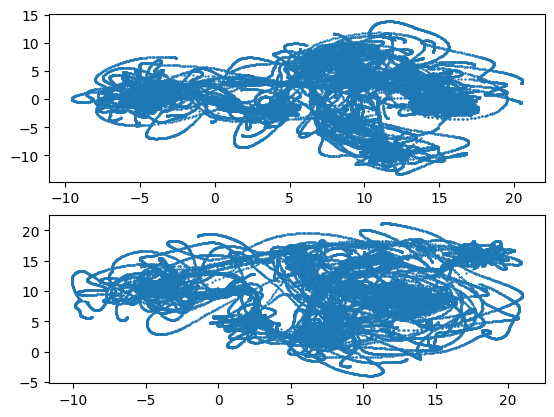

In [ ]:
plt.subplot(2,1,1)
plt.scatter(spk_emb_2D_top[:,0],spk_emb_2D_top[:,1],s = .5)


plt.subplot(2,1,2)
plt.scatter(spk_emb_2D_bottom[:,0],spk_emb_2D_bottom[:,1],s = .5)


plt.show()

[25 25 25 ...  1  1  1]


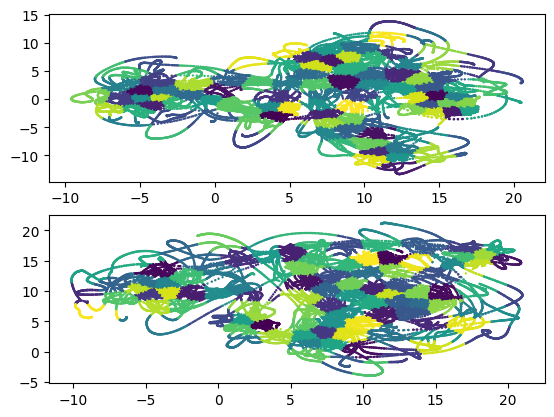

In [ ]:
from sklearn.cluster import KMeans


plt.subplot(2,1,1)
N = 100
kmeans1 = KMeans(n_clusters=N, random_state=0, n_init="auto").fit(spk_emb_2D_top)
labels1 = kmeans1.labels_
plt.scatter(spk_emb_2D_top[:,0],spk_emb_2D_top[:,1],s = .5,c = labels1)


plt.subplot(2,1,2)
kmeans2 = KMeans(n_clusters=N, random_state=0, n_init="auto").fit(spk_emb_2D_bottom)
labels2 = kmeans2.labels_
plt.scatter(spk_emb_2D_bottom[:,0],spk_emb_2D_bottom[:,1],s = .5, c = labels2)
print(labels1)

plt.show()

In [ ]:
import sklearn

infoArr = np.zeros_like(labels1).astype(float)
sliceRad = 30
for i in range(len(labels1)):
  start = max(0,i - sliceRad)
  end = min(len(labels1),i + sliceRad)

  L1 = labels1[start:end]
  L2 = labels2[start:end]
  score = sklearn.metrics.mutual_info_score(L1,L2)

  infoArr[i] = score



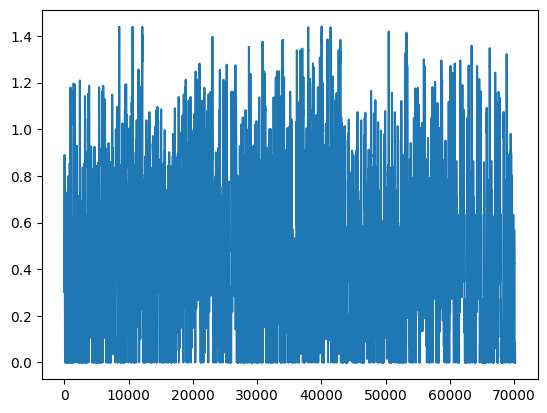

In [ ]:
plt.plot(infoArr)
# plt.xlim([0,2000])
# print(infoArr)

In [ ]:
plt.figure(figsize = (20,30))

# Turn our color array into an image with columns representing the neural state
color_emb_top = min_max_scale(spk_emb_1D_top).T[0]
color_emb_bottom = min_max_scale(spk_emb_1D_bottom).T[0]


def generateDispImg(color_emb,boutArr,boutChoice,interp = False, interpTimeNew = [],interpTimeOld = []):


  print(color_emb)
  goodInd = np.where(boutArr == boutChoice)[0]
  newColorEmb = color_emb[goodInd]
  interpolated_colors = np.interp(interpTimeNew, interpTimeOld, newColorEmb)
  dispImg = np.tile(interpolated_colors,(10,1))
  # print(interpolated_colors)
  # if interp == True:
  #   interpolated_colors = np.zeros((newColorEmb.shape[0], len(interpTimeNew)))

  #   for i in range(newColorEmb.shape[0]):
  #       interpolated_colors[i] = np.interp(interpTimeNew, interpTimeOld, newColorEmb[i])
  #   newColorEmb = interpolated_colors

  # dispImg = np.zeros((20,newColorEmb.shape[1]))

  # for column in range(dispImg.shape[1]):
  #   dispImg[:,column] = newColorEmb[:,column]

  return dispImg

masterDispImg = None
for i in range(1,5):

  bout_audio = Vocal_data[i - 1]
  NFFT = 512
  noverlap = 450
  logAdditive = 2

  f, tSpec, Sxx = scipy.signal.spectrogram(bout_audio, FS,nfft = NFFT,noverlap = noverlap,nperseg = NFFT)
  logSpec = np.log(Sxx + logAdditive)
  logSpec= np.flip(logSpec,0)

  colormap = plt.get_cmap('viridis')
  norm = plt.Normalize(vmin=np.min(logSpec), vmax=np.max(logSpec))

  # Apply the colormap to the normalized data to get RGB values
  rgb_array_spec = colormap(norm(logSpec))[:, :, :3]


  # info
  iImg = generateDispImg(infoArr,boutArray,i,interp = True, interpTimeOld = relTime, interpTimeNew = tSpec)

  colormap = plt.get_cmap('viridis')
  norm = plt.Normalize(vmin=np.min(iImg), vmax=np.max(iImg))
  iImg = colormap(norm(iImg))[:, :, :3]





  dispImg3 = np.zeros_like(iImg)


  dispImg = np.vstack((rgb_array_spec,iImg,dispImg3))

  try:
    masterDispImg = np.vstack((masterDispImg,dispImg))
  except:
    masterDispImg = dispImg

plt.imshow(masterDispImg,aspect = 'auto')

ax = plt.gca()
ax.get_yaxis().set_visible(False)
plt.title(f'{bird} Spectrograms with RA,HVC Neural Colorizations bouts 1-30')
plt.show()



NameError: ignored

<Figure size 2000x3000 with 0 Axes>

Cell Grouping

In [ ]:

plt.figure(figsize = (30,20))
plt.imshow(aveSpike,origin = 'lower',aspect = 'auto') #,extent = extentInput


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from scipy import stats
from scipy.cluster import hierarchy

def obtainXC(inputMat):

  numUnits = inputMat.shape[0]

  xc_mat = np.zeros((numUnits,numUnits))

  for unit1 in range(numUnits):
    # print(unit1)
    for unit2 in range(numUnits):

      unitData1 = inputMat[unit1,:]
      unitData2 = inputMat[unit2,:]

      # unitData1 = stats.zscore(unitData1)
      # unitData2 = stats.zscore(unitData2)

      # CHOOSE A METRIC
      xc = np.dot(unitData1,unitData2)

      xc_mat[unit1,unit2] = xc

  # Perform hierarchical clustering
  linkage_matrix = hierarchy.linkage(xc_mat, method='complete')

  # Reorder rows
  leaves_order = hierarchy.leaves_list(linkage_matrix)

  reordered_matrix = xc_mat[leaves_order][:, leaves_order]



  return xc_mat,leaves_order,reordered_matrix

[[1.55555556e-02 1.11111111e-02 5.55555556e-03 ... 0.00000000e+00
  0.00000000e+00 2.44444444e-02]
 [1.11111111e-02 2.38444444e+00 5.10000000e-01 ... 0.00000000e+00
  0.00000000e+00 1.91555556e+00]
 [5.55555556e-03 5.10000000e-01 1.22000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.18333333e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.44444444e-02 1.91555556e+00 1.18333333e+00 ... 0.00000000e+00
  0.00000000e+00 7.76888889e+00]]


<ipython-input-19-426db5bc63b9>:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(xc_new))


Text(0.5, 1.0, 'Raw Similarity Matrix for M1 Baseline')

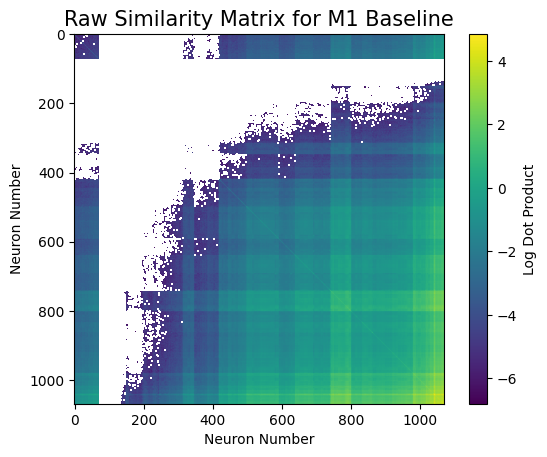

In [ ]:
xc_mat,unit_order,xc_new = obtainXC(aveSpike)

plt.imshow(np.log(xc_new))
print(xc_mat)
cbar = plt.colorbar()
cbar.set_label('Log Dot Product',fontsize = 10)
plt.xlabel('Neuron Number',fontsize = 10)
plt.ylabel('Neuron Number',fontsize = 10)
plt.title('Raw Similarity Matrix for M1 Baseline',fontsize = 15)


In [ ]:
# Mutual Info via direct firing rate


# first average HVC and RA regions?
aveHVC = np.mean(aveSpike[:bottomSplit,:],axis = 0)
aveRA = np.mean(aveSpike[topSplit:,:],axis = 0)

print(aveRA.shape)
print(aveHVC.shape)



(2438,)
(2438,)


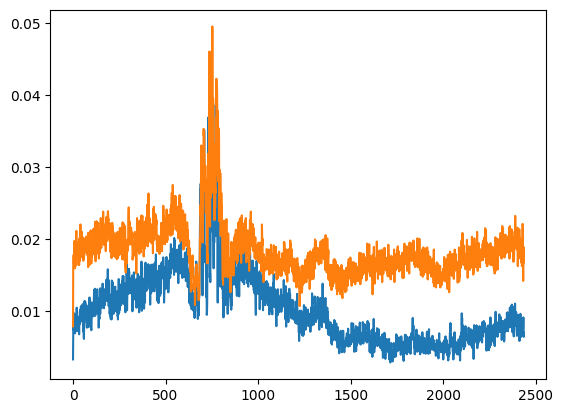

In [ ]:
plt.plot(aveRA)
plt.plot(aveHVC)

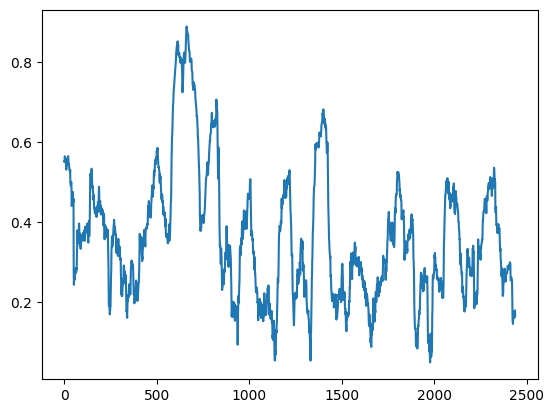

In [ ]:
import sklearn
from scipy.stats import pearsonr

infoArr = np.zeros_like(aveRA).astype(float)
sliceRad = 50
for i in range(len(aveRA)):
  start = max(0,i - sliceRad)
  end = min(len(aveRA),i + sliceRad)

  L1 = aveRA[start:end]
  L2 = aveHVC[start:end]
  # score = sklearn.metrics.mutual_info_score(L1,L2)
  score = pearsonr(L1,L2)[0]
  infoArr[i] = score

plt.plot(infoArr)